##### target: `health`

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv('../data/raw/new_york_tree_census_2015.csv')

health
Good       0.773412
Fair       0.141131
Missing    0.046237
Poor       0.039220
Name: proportion, dtype: float64


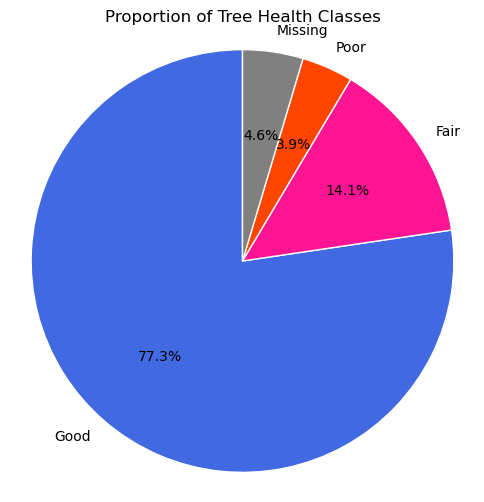

In [3]:
target = df['health'].fillna('Missing')
print(target.value_counts(dropna=False,normalize=True))
labels = ["Good", "Fair", "Poor", "Missing"]
counts = target.value_counts(dropna=False).reindex(labels).fillna(0)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(
    counts,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=["royalblue", "deeppink", "orangered", "grey"],
    wedgeprops=dict(edgecolor="w")
)
ax.set_title("Proportion of Tree Health Classes")
ax.axis("equal")
plt.savefig('../reports/figures/class_proportions.png',dpi=600,transparent=True,bbox_inches='tight')
plt.show()

In [4]:
# help(plt.savefig)

##### `health` sample map

/var/folders/y8/5sdb2rg957jchm7dmvcshj7h0000gn/T/ipykernel_13450/3155502080.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby("health", group_keys=False).apply(stratified_sample)


health
Good    0.810967
Fair    0.147935
Poor    0.041099
Name: proportion, dtype: float64
Sample size: 9538


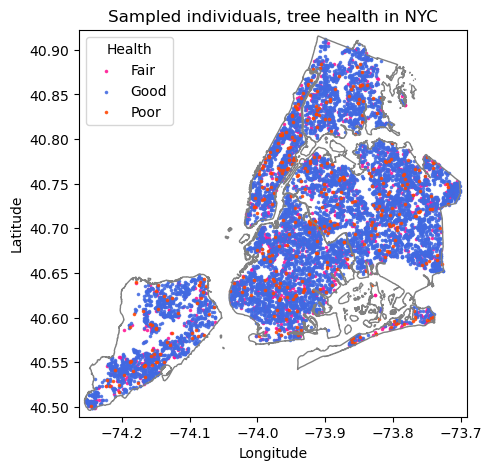

In [12]:
df = df.copy()
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# -----------------------------
# 2. Stratified sampling by 'health'
# -----------------------------
TOTAL_SAMPLE_SIZE = 10_000     # change this to whatever "decent" means for you
RANDOM_STATE = 42

# Get class proportions
props = df["health"].fillna("Missing").value_counts(normalize=True)

# How many samples to take from each class
n_per_class = (props * TOTAL_SAMPLE_SIZE).round().astype(int)

# Adjust in case rounding pushes us off the total
diff = TOTAL_SAMPLE_SIZE - n_per_class.sum()
if diff != 0:
    # Add/subtract the difference from the largest class
    largest_class = n_per_class.idxmax()
    n_per_class[largest_class] += diff

# Perform the stratified sample
def stratified_sample(group):
    label = group.name
    n = min(len(group), n_per_class[label])  # in case a group is too small
    return group.sample(n=n, random_state=RANDOM_STATE)

df_sample = df.groupby("health", group_keys=False).apply(stratified_sample)

print(df_sample["health"].value_counts(normalize=True))
print("Sample size:", len(df_sample))

# -----------------------------
# 3. Turn the sample into a GeoDataFrame
# -----------------------------
# Change these column names if needed
lat_col = "latitude"
lon_col = "longitude"

gdf_sample = gpd.GeoDataFrame(
    df_sample,
    geometry=gpd.points_from_xy(df_sample[lon_col], df_sample[lat_col]),
    crs="EPSG:4326"   # WGS84 (lat/lon)
)

# -----------------------------
# 4. Load NYC borough boundaries
# -----------------------------
# You need a borough boundaries file (shapefile or GeoJSON).
# For example, download from NYC Open Data and point to it here:
# e.g. "nyc_borough_boundaries.geojson" or ".shp"
boroughs = gpd.read_file("../references/nyc_boroughs.json")

# Make sure both are in the same CRS
boroughs = boroughs.to_crs(gdf_sample.crs)

# -----------------------------
# 5. Plot: NYC borough outlines + sampled points
# -----------------------------
fig, ax = plt.subplots(figsize=(5,5))

# Plot borough outlines
boroughs.boundary.plot(ax=ax, linewidth=1, color="grey")

# Color mapping for health categories
colors = {
    "Good": "royalblue",
    "Fair": "deeppink",
    "Poor": "orangered",
    "Missing": "grey"
}

# Plot points by health category
for label, subset in gdf_sample.groupby("health"):
    subset.plot(
        ax=ax,
        markersize=2.5,
        color=colors.get(label),
        label=label,
        alpha=0.8,
    )

# Zoom the plot roughly to the extent of your points
minx, miny, maxx, maxy = gdf_sample.total_bounds
ax.set_xlim(minx - 0.01, maxx + 0.01)
ax.set_ylim(miny - 0.01, maxy + 0.01)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Sampled individuals, tree health in NYC")
ax.legend(title="Health", loc="upper left")

# ax.set_aspect("equal")
plt.tight_layout()
plt.savefig('../reports/figures/sample_map.png',dpi=600,transparent=True,bbox_inches='tight')
plt.show()


##### user_type x health

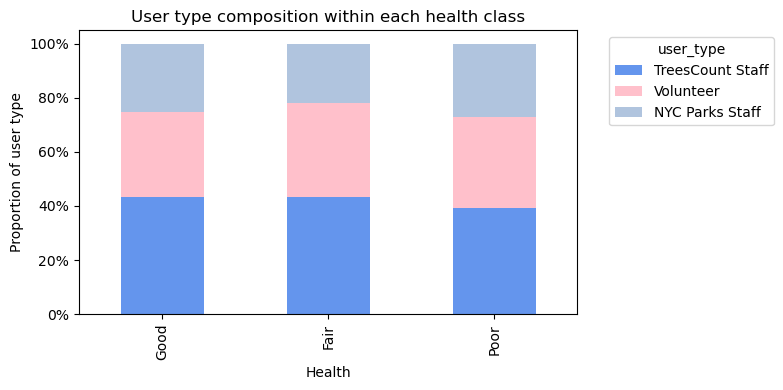

In [ ]:
from matplotlib.ticker import PercentFormatter
from matplotlib.colors import ListedColormap

health_order = ["Good", "Fair", "Poor"]
keeprows = df['health'].notna()
health = df["health"].dropna()
user_type = df["user_type"][keeprows]
user_order = user_type.value_counts().index

proportions = (
    pd.crosstab(health, user_type, normalize="index")
      .reindex(health_order)
      .reindex(columns=user_order, fill_value=0)
)

fig, ax = plt.subplots(figsize=(8, 4))

custom_colors = ['cornflowerblue','pink','lightsteelblue']
cmap = ListedColormap(custom_colors, name="health_map")

proportions.plot(kind="bar", stacked=True, ax=ax, colormap=cmap)

ax.set_ylabel("Proportion of user type")
ax.set_xlabel("Health")
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.set_title("User type composition within each health class")
ax.legend(title="user_type", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig(
    '../reports/figures/user_type_by_health.png',
    dpi=600,
    transparent=True,
    bbox_inches='tight')
plt.show()

##### state plane coords heatmap

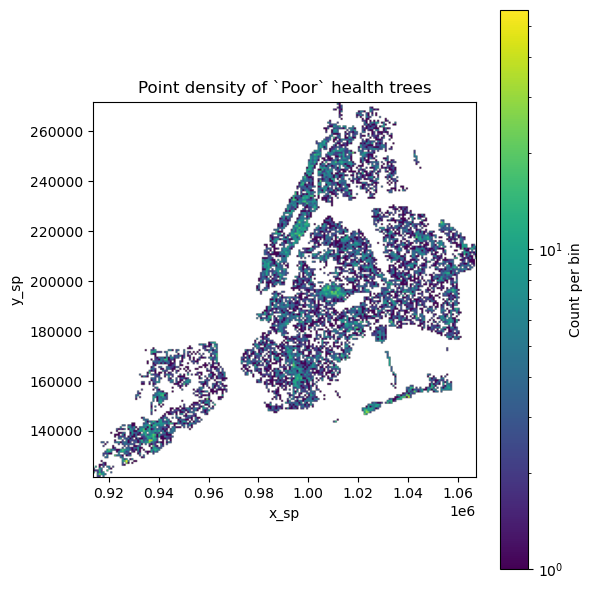

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Load data with x/y columns
df = pd.read_csv('../data/raw/new_york_tree_census_2015.csv')
good_indx = df['health'] == 'Poor'
x = df[good_indx]['x_sp'].to_numpy()
y = df[good_indx]['y_sp'].to_numpy()

# Choose bin counts (discrete grid)
bins_x = 200   # increase for finer resolution
bins_y = 200

# 2D histogram (density grid)
H, xedges, yedges = np.histogram2d(x, y, bins=[bins_x, bins_y])

# Plot as discrete heatmap
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(
    H.T,                     # transpose so axes align
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='viridis',
    norm=LogNorm(vmin=1, vmax=H.max())  # log scaling helps with skewed counts
)
ax.set_xlabel('x_sp')
ax.set_ylabel('y_sp')
ax.set_title('Point density of `Poor` health trees')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Count per bin')

plt.tight_layout()
plt.savefig('../reports/figures/xy_density_heatmap_poor.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()

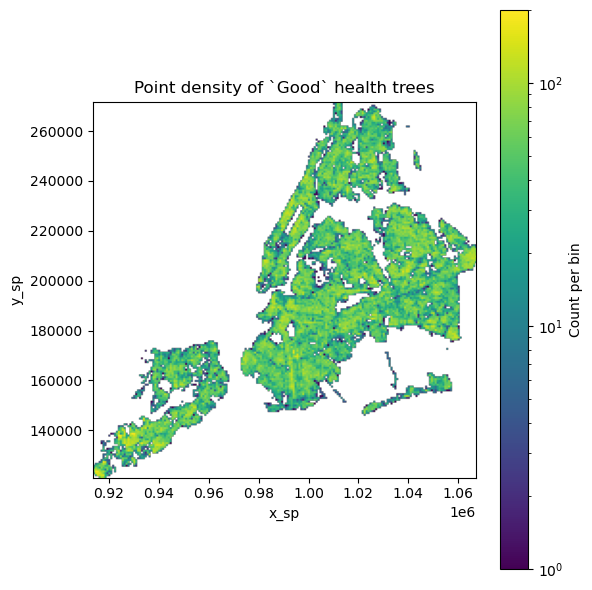

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Load data with x/y columns
df = pd.read_csv('../data/raw/new_york_tree_census_2015.csv')
good_indx = df['health'] == 'Good'
x = df[good_indx]['x_sp'].to_numpy()
y = df[good_indx]['y_sp'].to_numpy()

# Choose bin counts (discrete grid)
bins_x = 200   # increase for finer resolution
bins_y = 200

# 2D histogram (density grid)
H, xedges, yedges = np.histogram2d(x, y, bins=[bins_x, bins_y])

# Plot as discrete heatmap
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(
    H.T,                     # transpose so axes align
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='viridis',
    norm=LogNorm(vmin=1, vmax=H.max())  # log scaling helps with skewed counts
)
ax.set_xlabel('x_sp')
ax.set_ylabel('y_sp')
ax.set_title('Point density of `Good` health trees')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Count per bin')

plt.tight_layout()
plt.savefig('../reports/figures/xy_density_heatmap_good.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()

#### appendix

In [29]:
import math

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle


def plot_colortable(colors, *, ncols=4, sort_colors=True):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        names = sorted(
            colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
    else:
        names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * ncols + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * ncols)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

# plot_colortable(mcolors.CSS4_COLORS)
# plt.show()